In [1]:
import os
import re
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn
#import torchsummary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split


import segmentation_models_pytorch as smp

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
#from load_data import *
from run_length_encoding import *
#from load_model import *
from load import *
from loss import *

from collections import OrderedDict

In [2]:

def get_model(model_str: str):
    if model_str == 'Unet':
        return smp.Unet
    elif model_str == 'FPN':
        return smp.FPN
    elif model_str == 'DeepLabV3Plus':
        return smp.DeepLabV3Plus
    elif model_str == 'UnetPlusPlus':
        return smp.UnetPlusPlus
    elif model_str == 'PAN':
        return smp.PAN
    elif model_str == 'MAnet':
        return smp.MAnet
    elif model_str == 'PSPNet':
        return smp.PSPNet
    
    
def get_optimizer(optimizer_str: str):
    if optimizer_str == 'SGD':
        optimizer = torch.optim.SGD
    elif optimizer_str == 'Adam':
        optimizer = torch.optim.Adam
    elif optimizer_str == 'AdamW':
        optimizer = torch.optim.AdamW
    else:
        optimizer = None

    return optimizer

def extract_numbers(string):
    numbers = re.findall(r'\d+', string)
    numbers_list = np.array([int(number) for number in numbers])
    #print(numbers_list)
    return np.max(numbers_list)



# 가장 최근에 저장된 모델의 weight를 가져옵니다.
def get_latest_checkpoint(checkpoint_dir):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, '*.pth'))
    if not checkpoint_files:
        #raise FileNotFoundError(f"No checkpoint files found in {checkpoint_dir}")
        return 0, None

    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    last_epoch = extract_numbers(latest_checkpoint)
    
    return last_epoch, latest_checkpoint


def get_weight(path): 
    '''
    path : model weight가 저장된 디렉토리
    '''
    last_epoch, last_ckpt_path = get_latest_checkpoint(path)
    if last_epoch == 0:
        return False
    else:
        last_ckpt = torch.load(last_ckpt_path)
        return last_epoch, last_ckpt



def get_multi_gpu_weight(path):
    check_point = torch.load(path)
    new_state_dict = OrderedDict()
    for k, v in check_point.items():
        new_state_dict[k[7:]] = v
    return new_state_dict



def get_transform_for_train(version:int=3):
    
    transform_1 = A.Compose(
        [
            A.Normalize(),
            A.OneOf(
                [
                    A.CoarseDropout(50,50,50,15),
                    A.RandomGridShuffle(grid=(2,2))
                ], p = 0.4),
            A.OneOf(
                [
                    # 블러처리
                    A.ColorJitter(),
                    A.ChannelShuffle()             
                ], p = 0.4),
            A.OneOf(
                [
                    #내가 쓰고자하는 모델에서 input size가 어떤게 적합한가
                    A.Resize (224,224),
                    A.RandomCrop(224,224)
                ],p = 1),
            #A.Resize (224,224),
            ToTensorV2()
        ]
    )
    transform_2 = A.Compose(
        [   
            A.Resize(224, 224),
            A.MinMaxNormalize(),
            A.OneOf([
                A.Flip(p=1),
                A.Rotate(p=1),
            ],p = 1),
            ToTensorV2()
        ]
    )
    # for train_20849_2.csv
    transform_3 = A.Compose(
        [   
            A.Normalize(),
            ToTensorV2()
        ]
    )
    
    if version == 1:
        return transform_1
    elif version == 2:
        return transform_2
    elif version == 3:
        return transform_3


def get_transform_for_test():
    transform = A.Compose(
        [   
            A.Normalize(),
            ToTensorV2()
        ]
    )
    return transform


def get_dataset(csv_path, transform, infer = False):
    return SatelliteDataset(csv_file = csv_path, transform = transform, infer = infer)


def random_split_train_valid(dataset):
    data_size = len(dataset)
    train_size = int(data_size*TRAIN_SET_RATIO)
    valid_size = data_size - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
    return train_dataset, valid_dataset


def get_data_loader(dataset, is_Train = True):
    return DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = is_Train)

In [3]:
BATCH_SIZE = 1

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPUs 0 and 1 to use

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
ARCHITECTURE = 'DeepLabV3Plus'
ENCODER = 'timm-efficientnet-b1' #timm-regnety_016
ENCODER_b5 = 'timm-efficientnet-b5' #timm-regnety_016
ENCODER_WEIGHT= 'noisy-student' #imagenet
N_CLASSES = 1
ACTIVATION = None
OPTIMIZER = 'AdamW'
# 모델 및 백본 변경시 수정 필요.
#SAVED_MODEL_PATH = '/root/jupyter/Dacon/deeplabv3p/model_focal_loss/'


In [8]:
#ckpt = torch.load('/root/jupyter/Dacon/deeplabv3p/modelArchive/model_save_b1_1024/weight_epoch-0110.pth')
ckpt_focal = torch.load('/root/jupyter/Dacon/deeplabv3p/modelArchive/model_b5_focal_loss/weight_epoch-0250.pth')
ckpt_349 = torch.load('/root/jupyter/Dacon/deeplabv3p/modelArchive/model_save_b1/weight_epoch-0349.pth')

In [9]:
model_focal = get_model(ARCHITECTURE)
model_focal = model_focal(classes=N_CLASSES,
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHT,
                activation=ACTIVATION)
    

In [10]:
model_focal = nn.DataParallel(model_focal) # multiple GPUs
model_focal.load_state_dict(ckpt_focal, strict=False)

<All keys matched successfully>

In [11]:
model_349 = get_model(ARCHITECTURE)
model_349 = model_349(classes=N_CLASSES,
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHT,
                activation=ACTIVATION)

In [12]:
model_349.load_state_dict(ckpt_349, strict=False)

<All keys matched successfully>

In [13]:
model_349.to(DEVICE)
model_focal.to(DEVICE)


DataParallel(
  (module): DeepLabV3Plus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
    

In [14]:
transform_train = get_transform_for_train(version=3)

In [14]:

# Dataset and DataLoader
dataset = get_dataset(csv_path ='/root/jupyter/Dacon/deeplabv3p/test.csv', transform = transform_train, infer = True)
train_dataloader = get_data_loader(dataset, is_Train = False)

In [15]:
train_iter = iter(train_dataloader)
iter_num = 0

# Next Image

/root/jupyter/Dacon/deeplabv3p/test_img/TEST_00083.png


'\nnp.printoptions(threshold=np.inf, linewidth=np.inf)\nprint(outputs_349.squeeze(0).squeeze(0).cpu().detach().numpy())\nprint(np.max(outputs_349.squeeze(0).squeeze(0).cpu().detach().numpy()))\nprint(np.min(outputs_349.squeeze(0).squeeze(0).cpu().detach().numpy()))\nprint()\nprint(torch.sigmoid(outputs_349).squeeze(0).squeeze(0).cpu().detach().numpy())\nprint(np.max(torch.sigmoid(outputs_349).squeeze(0).squeeze(0).cpu().detach().numpy()))\nprint(np.min(torch.sigmoid(outputs_349).squeeze(0).squeeze(0).cpu().detach().numpy()))\n'

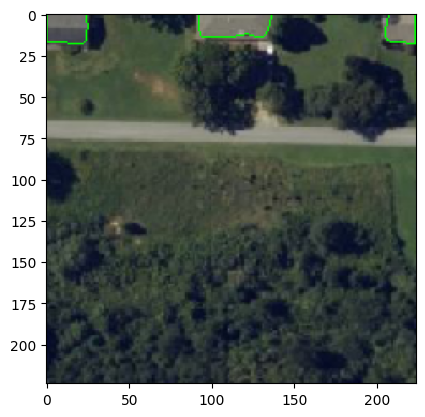

In [196]:
path = '/root/jupyter/Dacon/deeplabv3p/test_img/TEST_{num:00005d}.png'.format(num=iter_num)
print(path)
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img
#img = img.reshape(224,224,3)
transform_img = transform_train(image=img)['image']

model_349.eval()
model_focal.eval()

transform_img = transform_img.to(device=DEVICE, dtype = torch.float)
transform_img = transform_img.reshape((1,3,224,224))

# bce 349 inference
outputs_349 = model_349(transform_img)

outputs_349 = torch.sigmoid(outputs_349).cpu().detach().numpy()
outputs_349 = (outputs_349.squeeze(0).squeeze(0) > .5).astype(np.uint8)

# focal 250 inference
outputs_focal = model_focal(transform_img)
#outputs_focal = outputs_focal > 7.
outputs_focal = torch.sigmoid(outputs_focal).cpu().detach().numpy()
outputs_focal = (outputs_focal.squeeze(0).squeeze(0) > .5).astype(np.uint8)

final_outputs = outputs_349 + outputs_focal
final_outputs = (final_outputs > .5).astype(np.uint8)

contours_349,_ = cv2.findContours(outputs_349, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours_focal,_ = cv2.findContours(outputs_focal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


contours_final, _ = cv2.findContours(final_outputs, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

contour_image_349 = cv2.drawContours(img, contours_349, -1, (0, 255, 0), 1)
contour_image_focal = cv2.drawContours(img_copy, contours_focal, -1, (0, 0, 255), 1)
iter_num += 1

#test_contour_image_final = cv2.drawContours(img, contours_final, -1, (255, 0, 0), 1)

#plt.figure(figsize=(10,10))
#plt.subplot(1,2,1)
plt.imshow(contour_image_349)

#plt.subplot(1,2,2)
#plt.imshow(contour_image_focal)
'''
np.printoptions(threshold=np.inf, linewidth=np.inf)
print(outputs_349.squeeze(0).squeeze(0).cpu().detach().numpy())
print(np.max(outputs_349.squeeze(0).squeeze(0).cpu().detach().numpy()))
print(np.min(outputs_349.squeeze(0).squeeze(0).cpu().detach().numpy()))
print()
print(torch.sigmoid(outputs_349).squeeze(0).squeeze(0).cpu().detach().numpy())
print(np.max(torch.sigmoid(outputs_349).squeeze(0).squeeze(0).cpu().detach().numpy()))
print(np.min(torch.sigmoid(outputs_349).squeeze(0).squeeze(0).cpu().detach().numpy()))
'''

In [ ]:
# Use Index

In [ ]:
IDX = 263

path = '/root/jupyter/Dacon/deeplabv3p/test_img/TEST_{num:00005d}.png'.format(num=IDX)
print(path)
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_349 = img
img_focal = img
#img = img.reshape(224,224,3)
transform_img = transform_train(image=img)['image']

model_349.eval()
model_focal.eval()

transform_img = transform_img.to(device=DEVICE, dtype = torch.float)
transform_img = transform_img.reshape((1,3,224,224))

# bce 349 inference
outputs_349 = model_349(transform_img)
outputs_349 = torch.sigmoid(outputs_349).cpu().detach().numpy()
outputs_349 = (outputs_349.squeeze(0).squeeze(0) > .5).astype(np.uint8)

contours_349, _ = cv2.findContours(outputs_349, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
test_contour_image_349 = cv2.drawContours(img_349, contours_349, -1, (255, 0, 0), -1)

# focal 250 inference
outputs_focal = model_focal(transform_img)
outputs_focal = torch.sigmoid(outputs_focal).cpu().detach().numpy()
outputs_focal = (outputs_focal.squeeze(0).squeeze(0) > .5).astype(np.uint8)

contours_focal, _ = cv2.findContours(outputs_focal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
test_contour_image_focal = cv2.drawContours(img_focal, contours_focal, -1, (255, 0, 0), -1)
'''
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('349')
plt.imshow(test_contour_image_349)
'''
plt.subplot(1,2,2)
plt.title('focal')
plt.imshow(test_contour_image_focal)



# focal thresholding

/root/jupyter/Dacon/deeplabv3p/test_img/TEST_58334.png


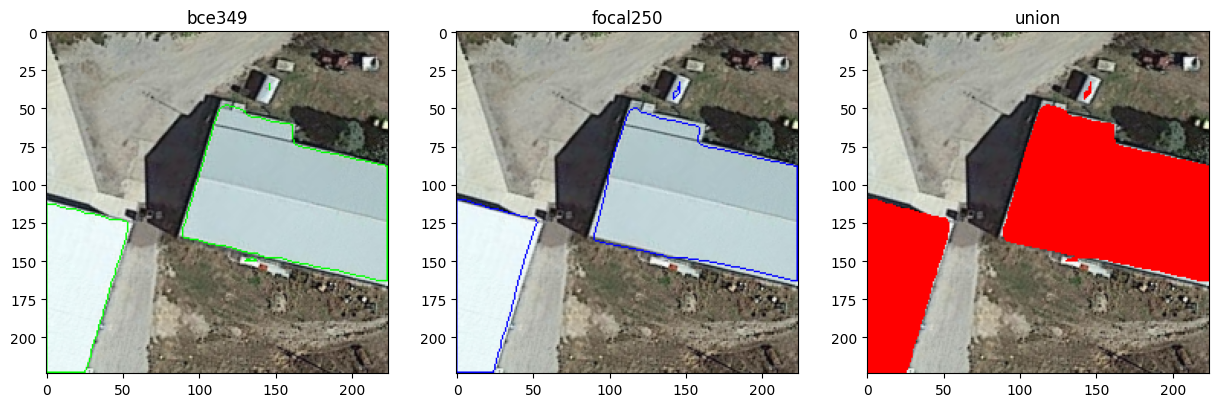

In [29]:
IDX = 58334

path = '/root/jupyter/Dacon/deeplabv3p/test_img/TEST_{num:00005d}.png'.format(num=IDX)
print(path)
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img
transform_img = transform_train(image=img)['image']

model_349.eval()
model_focal.eval()

transform_img = transform_img.to(device=DEVICE, dtype = torch.float)
transform_img = transform_img.reshape((1,3,224,224))

# bce 349 inference
outputs_349 = model_349(transform_img)
'''
print('bce range')
print(outputs_349.max().item())
print(outputs_349.min().item())
print()
'''
outputs_349 = torch.sigmoid(outputs_349).cpu().detach().numpy()
outputs_349 = (outputs_349.squeeze(0).squeeze(0) > .5).astype(np.uint8)

# focal 250 inference
outputs_focal = model_focal(transform_img)
'''
print('focal range')
print(outputs_focal.max().item())
print(outputs_focal.min().item())
print()
'''
outputs_focal[outputs_focal < outputs_focal.max()*.4] = outputs_focal.min()
outputs_focal = torch.sigmoid(outputs_focal).cpu().detach().numpy()
outputs_focal = (outputs_focal.squeeze(0).squeeze(0) > .75).astype(np.uint8)

final_outputs = outputs_349 + outputs_focal
final_outputs = (final_outputs > .5).astype(np.uint8)

contours_349,_ = cv2.findContours(outputs_349, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours_focal,_ = cv2.findContours(outputs_focal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


contours_final, _ = cv2.findContours(final_outputs, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

contour_image_349 = cv2.drawContours(img, contours_349, -1, (0, 255, 0), 1)

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
contour_image_focal = cv2.drawContours(img, contours_focal, -1, (0, 0, 255), 1)

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
contour_image_final = cv2.drawContours(img, contours_final, -1, (255, 0,0), -1)

#test_contour_image_final = cv2.drawContours(img, contours_final, -1, (255, 0, 0), 1)

plt.figure(figsize=(15,30))
plt.subplot(1,3,1)
plt.title('bce349')
plt.imshow(contour_image_349)

plt.subplot(1,3,2)
plt.title('focal250')
plt.imshow(contour_image_focal)

plt.subplot(1,3,3)
plt.title('union')
plt.imshow(contour_image_final)

#np.printoptions(threshold=np.inf, linewidth=np.inf)
#print(outputs_349.squeeze(0).squeeze(0).cpu().detach().numpy())
#print(np.max(outputs_349.squeeze(0).squeeze(0).cpu().detach().numpy()))
#print(np.min(outputs_349.squeeze(0).squeeze(0).cpu().detach().numpy()))
#print()
#print(torch.sigmoid(outputs_349).squeeze(0).squeeze(0).cpu().detach().numpy())
#print(np.max(torch.sigmoid(outputs_349).squeeze(0).squeeze(0).cpu().detach().numpy()))
#print(np.min(torch.sigmoid(outputs_349).squeeze(0).squeeze(0).cpu().detach().numpy()))


# MAKE SUBMIT

In [16]:
from skimage import io, morphology
transform_test = get_transform_for_test()
test_dataset = SatelliteDataset(csv_file='/root/jupyter/Dacon/deeplabv3p/test.csv', transform=transform_test, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

softmax = nn.Softmax(
with torch.no_grad():
    model_349.eval()
    model_focal.eval()
    
    result = []
    
    for images in tqdm(test_dataloader):
        images = images.float().to(DEVICE)
        
        # 1. model output
        outputs_349 = model_349(images)
        # 2. activation func and thresholding
        masks_349 = torch.Softmax(outputs_349).cpu().numpy()
        #masks_349 = (masks_349 > .5).astype(np.uint8) 
        
        
        outputs_focal = model_focal(images)
        masks_focal = torch.Softmax(outputs_focal).cpu().numpy()
            
        #masks_focal = (masks_focal > .75).astype(np.uint8) 
       
        final_outputs = (masks_349 + masks_focal) // 2
        final_outputs = (final_outputs > .5).astype(np.uint8)
        
        for i in range(len(images)):
            mask_rle = rle_encode(final_outputs[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)
            
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

# change the file name.
# format : submit_{model_epoch}.csv
submit.to_csv('./submit/submit_ensemble_softmax_p5_focal250_bce349_V3.csv', index=False)

  0% 0/474 [00:00<?, ?it/s]


AttributeError: module 'torch' has no attribute 'Softmax'